In [40]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [41]:
# LBM D2Q9 lattice scheme configuration
##############
#  6   2   5
#   \  |  /
# 3 —— 0 —— 1
#   /  |  \
#  7   4   8
##############

Nq = 9  # Number of lattice directions
Nx = 16  # Number of grid points in x-direction
Ny = 16  # Number of grid points in y-direction
Nt = 20  # Number of timesteps

# Lattice vector definition
ei = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
ci = jnp.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], 
               [0, 0, 1, 0, -1, 1, 1, -1, -1]])

# Lattice weights definition
omega = 1.0
weights = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

In [42]:
# Meshgrid definition in 2D XY domain
t = jnp.arange(Nt)
xm = jnp.arange(Nx)
ym = jnp.arange(Ny)
X, Y = jnp.meshgrid(xm, ym, indexing='ij')

In [43]:
# Density initialization
rho = jnp.full((Nx, Ny), 0.1)
rho = rho.at[:,int(Nx/2)-1].set(0.3)
rho = rho.at[int(Nx/2-1),:].set(0.3)

# Parameters for velocity field
A, B = 0.2, 0.2  # Amplitude of velocity components
a, b = 2.0, 2.0     # Frequency parameters

# Initialize velocity field
u = jnp.zeros((Nx, Ny, 2))
x = jnp.linspace(0.2 * jnp.pi, Nx)
y = jnp.linspace(0.2 * jnp.pi, Ny)

# Populate the velocity field
for i in range(Nx):
    for j in range(Ny):
        u = u.at[i, j, 0].set(A * jnp.cos(a * x[i]) * jnp.sin(b * y[j]))
        u = u.at[i, j, 1].set(B * jnp.sin(a * x[i]) * jnp.cos(b * y[j]))

In [44]:
# fi field initialization
fi = jnp.zeros((Nx, Ny, Nq))
for i, wi in zip(ei, weights):
    projected_v = ci[0][i] * u[:, :, 0] + ci[1][i] * u[:, :, 1]
    fi = fi.at[:, :, i].set(rho * wi * (1 + 3 * projected_v + 9 * projected_v**2 / 2 - 3 * (u[:, :, 0]**2 + u[:, :, 1]**2) / 2))

g_jk = jnp.tensordot(fi, fi, axes=0)

In [45]:
def streaming(fi, g_jk):
    for i in ei:
        # Propagate fi value in each corresponding direction using jnp.roll
        fi = fi.at[:, :, i].set(jnp.roll(fi[:, :, i], ci[0][i], axis=0)) # roll along x
        fi = fi.at[:, :, i].set(jnp.roll(fi[:, :, i], ci[1][i], axis=1)) # roll along y

    for j in ei:
        g_jk = g_jk.at[:, :, j, :, :, :].set(jnp.roll(g_jk[:, :, j, :, :, :], ci[0][j], axis=0))
        g_jk = g_jk.at[:, :, j, :, :, :].set(jnp.roll(g_jk[:, :, j, :, :, :], ci[1][j], axis=1))

    for k in ei:
        g_jk = g_jk.at[:, :, :, :, :, k].set(jnp.roll(g_jk[:, :, :, :, :, k], ci[0][k], axis=3))
        g_jk = g_jk.at[:, :, :, :, :, k].set(jnp.roll(g_jk[:, :, :, :, :, k], ci[1][k], axis=4))

    return fi, g_jk

In [46]:
def get_matrix(omega):
    # Calculate matrix A
    ci_cj = jnp.tensordot(ci[0], ci[0], axes=0) + jnp.tensordot(ci[1], ci[1], axes=0) # ci is equivalent to cj
    L_ij = jnp.transpose(weights * (1 + 3 * ci_cj))
    A_ij = (1 - omega) * jnp.eye(Nq) + omega * L_ij

    # Calculate matrix B
    Q_ijk = jnp.zeros((Nq, Nq, Nq))
    for i in range(Nq):
        for j in range(Nq):
            for k in range(Nq):
                ci_cj = ci[0][i] * ci[0][j] + ci[1][i] * ci[1][j]
                ci_ck = ci[0][i] * ci[0][k] + ci[1][i] * ci[1][k]
                cj_ck = ci[0][j] * ci[0][k] + ci[1][j] * ci[1][k]
                Q_ijk = Q_ijk.at[i, j, k].set(9 * weights[i] * (ci_cj * ci_ck - cj_ck / 3))
    B_ijk = omega * Q_ijk
    
    return A_ij, B_ijk

In [47]:
def collision_BGK_2nd_carleman(fi_pre, A_ij, g_jk, B_ijk):
    f_j = jnp.squeeze(fi_pre)
    A_i = jnp.einsum('ij,NMj->NMi', A_ij, f_j) # N stands for x direction and M for y
    
    g_jk_dia = g_jk[X, Y, :, X, Y, :]
    
    B_i = jnp.einsum('ijk,NMjk->NMi', B_ijk, g_jk_dia)
    fi_collisioned = A_i + B_i
    
    AA = jnp.tensordot(A_ij, A_ij, axes=0)
    g_jk_collisioned = jnp.einsum('ikjl,NMkXYl->NMiXYj', AA, g_jk)
    
    return fi_collisioned, g_jk_collisioned

In [48]:
def get_macro_quantities(fi):
    rho = jnp.sum(fi, axis=2)  # Density
    ux = jnp.sum(fi * ci[0], 2) / rho
    uy = jnp.sum(fi * ci[1], 2) / rho
    
    return rho, ux, uy

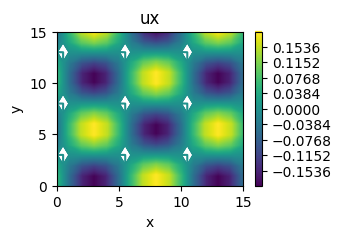

In [49]:
_, ux, uy = get_macro_quantities(fi)

plt.figure(figsize=(3, 2))
contour = plt.contour(X, Y, ux, levels=500, cmap='viridis')
plt.colorbar(contour)
plt.title("ux")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.3)
plt.show()

In [50]:
step = 0
fit = []
ux1, uy1, um1 = [], [], []
A_ij, B_ijk = get_matrix(omega)
for it in range(Nt):
    fit.append(fi)
    _, uxit, uyit = get_macro_quantities(fi)
    umit = jnp.linalg.norm(jnp.stack([uxit, uyit]), axis=0)
    
    fi, g_jk = collision_BGK_2nd_carleman(fi, A_ij, g_jk, B_ijk)
    fi, g_jk = streaming(fi, g_jk)
    
    ux1.append(uxit)
    uy1.append(uyit)
    um1.append(umit)
    print(step)
    step += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


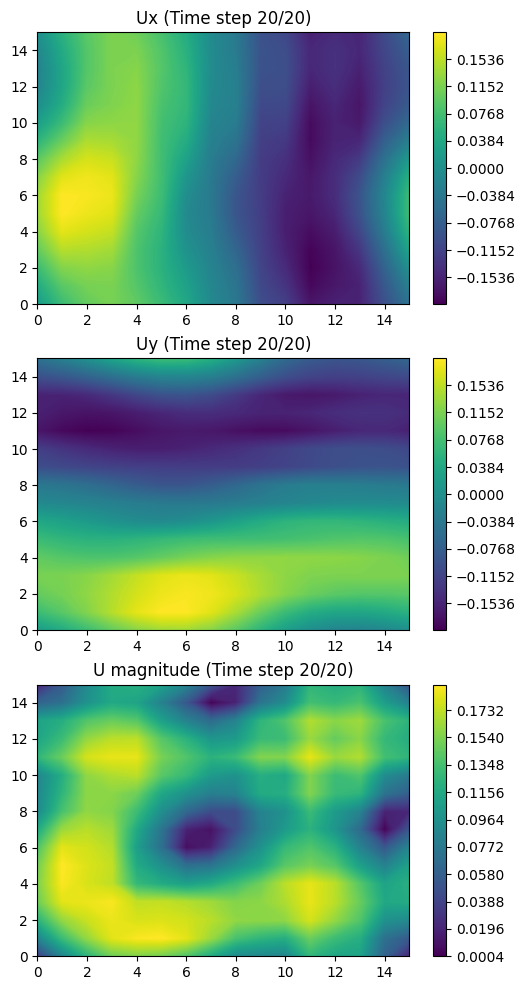

In [51]:
# Create animations for both velocity magnitude and curl
fig, axes = plt.subplots(3, 1, figsize=(6, 12))
ax1, ax2, ax3 = axes
frames = Nt

def init():
    # For ux
    contour1 = ax1.contourf(X, Y, ux1[0], levels=500, cmap='viridis')
    plt.colorbar(contour1, ax=ax1)

    # For uy
    contour2 = ax2.contourf(X, Y, uy1[0], levels=500, cmap='viridis')
    plt.colorbar(contour2, ax=ax2)
    
    # For u magnitude
    contour3 = ax3.contourf(X, Y, um1[0], levels=500, cmap='viridis')
    plt.colorbar(contour3, ax=ax3)

def update(frame):
    # For ux
    ax1.clear()
    ax1.contourf(X, Y, ux1[frame], levels=500, cmap='viridis')
    ax1.set_title(f"Ux (Time step {frame + 1}/{frames})")

    # For uy
    ax2.clear()
    ax2.contourf(X, Y, uy1[frame], levels=500, cmap='viridis')
    ax2.set_title(f"Uy (Time step {frame + 1}/{frames})")

    # For u magnitude
    ax3.clear()
    ax3.contourf(X, Y, um1[frame], levels=500, cmap='viridis')
    ax3.set_title(f"U magnitude (Time step {frame + 1}/{frames})")
    
# Create the animation
anim = FuncAnimation(fig, update, frames, init_func=init, interval=500)
anim.save("Taylor_velocity_2nd CL.gif", writer="pillow", fps=500)
plt.show()

In [52]:
jnp.save("fi_2nd CL_taylor", fit)